# ML-7. Прогнозирование биологического ответа

![BioResponce](img/Bio_responce_title.jpg)

## 1. Введение

Цель практики - тренировка подбора гиперпараметров моделей МО:
* Обучить две модели: логистическую регрессию и случайный лес;  
* Выполнить подбор гиперпараметров с помощью базовых (GridSeachCV, RandomizedSearchCV) и продвинутых (Hyperopt, Optuna) методов оптимизации так, чтобы улучшать итоговую метрику;   
* Провести сравнение и понять преимущества и недостатки каждого из методов.


## 2. Знакомство с данными и baseline-решение



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import linear_model
from sklearn import ensemble
from sklearn import metrics
from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score

import hyperopt
from hyperopt import hp, fmin, tpe, Trials

%matplotlib inline

### 2.1. Описание задачи

Необходимо предсказать биологический ответ молекул (столбец 'Activity') по их химическому составу (столбцы D1-D1776).  

Данные представлены в формате csv.  Каждая строка представляет молекулу. Первый столбец 'Activity' содержит экспериментальные данные, описывающие фактический биологический ответ [0, 1]; остальные столбцы 'D1-D1776' представляют собой молекулярные *дескрипторы* — вычисляемые свойства, которые могут фиксировать некоторые характеристики молекулы, например размер, форму или состав элементов.  

Предварительная обработка не требуется, данные уже закодированы и нормализованы.  

В качестве метрики будем использовать **$F_1$-score**.


### 2.2. Знакомство с данными

In [ ]:
# Для работы в Google Colab
data = pd.read_csv('/content/sample_data/train_sem09.csv')
data.head()

# Для работы в IDE
# data = pd.read_csv('data/train_sem09.csv')

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


Убедимся, что данные не содержат пропусков:

In [ ]:
print('Количество пропусков в датафрейме:', (data.isnull().sum()).sum())

Количество пропусков в датафрейме: 0


Проверим сбалансированность классов:

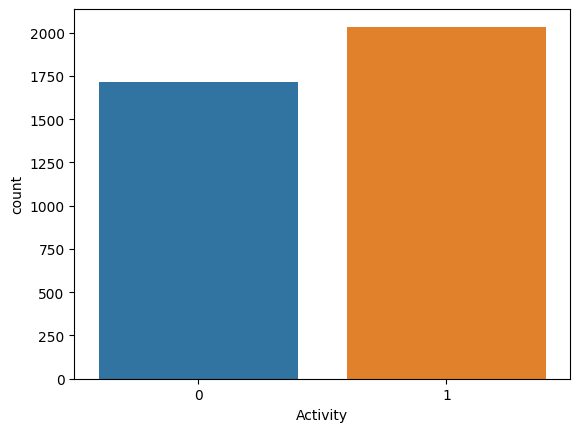

In [ ]:
sns.countplot(data=data, x='Activity');

### 2.3. Подготовка данных

Создаем матрицу наблюдений $X$ и вектор ответов $y$

In [ ]:
X = data.drop(['Activity'], axis=1)
y = data['Activity']

Разделяем выборку на тренировочную и тестовую в соотношении 80/20. Для сохранения соотношений целевого признака используем параметр stratify (стратифицированное разбиение). 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.2)

### 2.4. Обучение моделей с параметрами по умолчанию



#### **2.4.1. Логистическая регрессия**

Зафиксируем только метрики, которые были получены без дополнительной настройки, т.е со значениями гиперпараметров, установленных по умолчанию:

In [ ]:
#Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(max_iter = 500)

#Обучаем модель
log_reg.fit(X_train, y_train)

# Вычислим и выведем значение метрики
display('Метрики для базовых параметров LogisticRegresion:')
print("accuracy на тестовом наборе: {:.2f}".format(log_reg.score(X_test, y_test)))
y_test_pred = log_reg.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

'Метрики для базовых параметров LogisticRegresion:'

accuracy на тестовом наборе: 0.75
f1_score на тестовом наборе: 0.78


#### **2.4.2. Случайный лес**

In [ ]:
#Создаем объект класса случайный лес
rfcl = ensemble.RandomForestClassifier()

#Обучаем модель
rfcl.fit(X_train, y_train)

# Вычислим и выведем значение метрики
display('Метрики для базовых параметров RandomForestClassifier:')
print("accuracy на тестовом наборе: {:.2f}".format(rfcl.score(X_test, y_test)))
y_test_pred = rfcl.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

'Метрики для базовых параметров RandomForestClassifier:'

accuracy на тестовом наборе: 0.78
f1_score на тестовом наборе: 0.80


> ### **Промежуточный вывод по baseline-решению:**  
>  
> Как можно заметить, обе модели довольно неплохо справились с задачей предсказания без подбора гиперпараметров, при этом модель случайного леса несколько превзошла логистическую регрессию: 0,80 против 0,78 по метрике $F_1$-score, соответственно. По всей видимости, дело в хорошо подготовленных, нормализованных данных.  
>  
> Посмотрим, смогут ли показать лучшие результаты алгоритмы подбора гиперпарамтров.  
___

## 3. Базовая оптимизация гиперпараметров моделей

### 3.1. GridSearchCV

#### **3.1.1. Логистическая регрессия**  
Гиперпараметры логистической регрессии:
* в качестве алгоритма оптимизации используем lbfgs, sag, saga как наиболее подходящие; liblinear, newton-cholesky не подходят для нашего датасета с большим числом признаков и лишь в два раза большим числом наблюдений; newton-cg также не подойдет, т.к. предназначен для задач с распределением на множество классов;  
* в качестве типов регуляризации используем все доступные для алгоритмов типы, кроме elasticnet (он вызывает ошибку) - для этого потребуется создать список из словарей в параметре param_grid;  
* диапазон силы регуляризации C зададим с фокусом на диапазон от 0.01 до 0.1, зная заранее, что наилучшие результаты достигаются при наименьшем значении  C.  

In [ ]:
# Создаем сетку настраиваемых гиперпараметров
param_grid = [
    {'penalty' : ['l2', None],
     'solver': ['lbfgs', 'sag'],
     'C': [0.01, 0.05, 0.07, 0.5, 1]},
    {'penalty': ['l1', 'l2', None],
     'solver': ['saga'],
     'C': [0.01, 0.05, 0.1, 0.5, 1]}
]

# Создаем объект GridSearchCV с моделью логистической регрессии
grid_search = GridSearchCV(
    estimator = linear_model.LogisticRegression(random_state=42, max_iter=300), 
    param_grid = param_grid, 
    cv = 5,
    error_score = 'raise',
    n_jobs = -1
)

# Подбираем параметры, вычисляем и выводим метрики, а также наилучшие гиперпараметры
%time grid_search.fit(X_train, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(grid_search.score(X_test, y_test)))
y_test_pred = grid_search.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

CPU times: user 34.8 s, sys: 1.38 s, total: 36.2 s
Wall time: 30min 52s
accuracy на тестовом наборе: 0.76
f1_score на тестовом наборе: 0.79
Наилучшие значения гиперпараметров: {'C': 0.05, 'penalty': 'l2', 'solver': 'saga'}


In [ ]:
print("Наилучшее значение точности при кросс-валидаци: {:.2f}".format(grid_search.best_score_))

Наилучшее значение точности при кросс-валидаци: 0.77


In [ ]:
# Взглянем на результаты кросс-валидации
result_cv = pd.DataFrame(grid_search.cv_results_)
result_cv.head(2)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.264933,0.148088,0.073443,0.012773,0.01,l2,lbfgs,"{'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}",0.793333,0.776667,0.736667,0.765,0.741667,0.762667,0.021255,7
1,10.585104,1.107499,0.045126,0.026598,0.01,l2,sag,"{'C': 0.01, 'penalty': 'l2', 'solver': 'sag'}",0.793333,0.776667,0.736667,0.765,0.738333,0.762000,0.021944,9


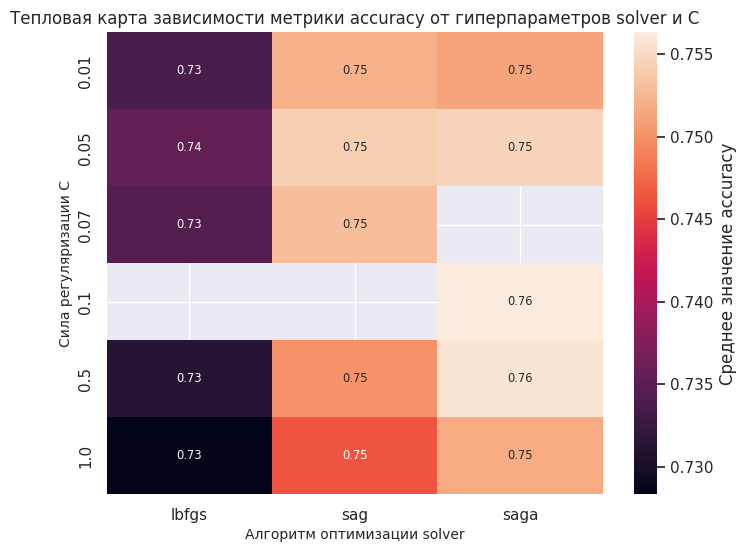

In [ ]:
# Отобразим, как менялась точность при различных гиперпараметрах
visual = pd.pivot_table(pd.DataFrame(grid_search.cv_results_),
                        values='mean_test_score',
                        index='param_C',
                        columns='param_solver')

# Построим тепловую карту
fig = plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(
    visual,
    annot=True,
    annot_kws={'fontsize':'x-small'},
    cbar_kws={'label':'Среднее значение accuracy'}
)
heatmap.set_title('Тепловая карта зависимости метрики accuracy от гиперпараметров solver и С', fontsize=12);
heatmap.set_xlabel('Алгоритм оптимизации solver', fontsize=10);
heatmap.set_ylabel('Сила регуляризации C', fontsize=10);

> **Вывод по подбору гиперпараметров логистической регрессии с помощью GridSearchCV**:  
> 1. Значения метрик accuracy и $F_1$-score улучшились на 0.01, что нельзя считать существенным приростом, а времени на их подбор затрачено 30 минут! По всей видимости, стоит попробовать другие методы оптимизации или использовать другую модель для решения данной задачи.  
>
> 2. На тепловой карте отсутствуют значения метрики при некоторых гиперпараметрах (`C = 0.1 при solver = 'lbfgs' и 'sag', C = 0.07 при solver = 'saga'`). Причина в неодинаковом списке значений `C` при создании сетки гиперпараметров. Ошибка обнаружена после оптимизации, и с учетом ее длительности (31 минута без пропущенных значений) повторение оптимизации представилось нецелесообразным Однако, если воспользоваться методикой заполнения пропусков с помощью медианного значения, то для алгоритма lbfgs можно ожидать значение 0.73, а для sag и saga - 0.75, что никак не скажется на итоговом результате.   
>
> 3. С незначительным отличием лучшие результаты метрики показал алгоритм оптимизации saga с типом регуляризации l2, а наилучший параметр C = 0.05.  
____

#### **3.1.2. Случайный лес**  
Гиперпараметры случайного леса:
* количество деревьев ограничим 200 сотнями и будем подбирать с шагом 30;  
* критерий информативности выберем из 'gini' и 'entropy';  
* максимальную глубину дерева подберем от 10 до 25 с шагом 5;  
* кол-во листьев на дереве - 5 или 7.  

In [ ]:
# Создаем сетку настраиваемых гиперпараметров
param_grid = {
    'n_estimators' : list(range(100, 200, 30)),
    'criterion' : ['gini', 'entropy'],
    'max_depth': [10, 15, 20, 25],
    'min_samples_leaf' : [5, 7],
}

# Создаем объект GridSearchCV с моделью случайного леса
grid_search_1 = GridSearchCV(
    estimator = ensemble.RandomForestClassifier(random_state=42), 
    param_grid = param_grid, 
    cv = 5,
    error_score = 'raise',
    n_jobs = -1
)

# Подбираем параметры, вычисляем и выводим метрики, а также наилучшие гиперпараметры
%time grid_search_1.fit(X_train, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(grid_search_1.score(X_test, y_test)))
y_test_pred = grid_search_1.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_1.best_params_))

CPU times: user 4.16 s, sys: 318 ms, total: 4.48 s
Wall time: 6min 13s
accuracy на тестовом наборе: 0.77
f1_score на тестовом наборе: 0.80
Наилучшие значения гиперпараметров: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 5, 'n_estimators': 190}


In [ ]:
print("Наилучшее значение точности при кросс-валидаци: {:.2f}".format(grid_search_1.best_score_))

Наилучшее значение точности при кросс-валидаци: 0.80


In [ ]:
# Взглянем на результаты кросс-валидации
result_cv = pd.DataFrame(grid_search_1.cv_results_)
result_cv.head(2)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.604566,0.393434,0.049310,0.020965,gini,10,5,100,"{'criterion': 'gini', 'max_depth': 10, 'min_sa...",0.825000,0.786667,0.765,0.781667,0.756667,0.783000,0.023650,56
1,2.726907,0.368352,0.073612,0.016929,gini,10,5,130,"{'criterion': 'gini', 'max_depth': 10, 'min_sa...",0.836667,0.786667,0.755,0.780000,0.760000,0.783667,0.029029,53


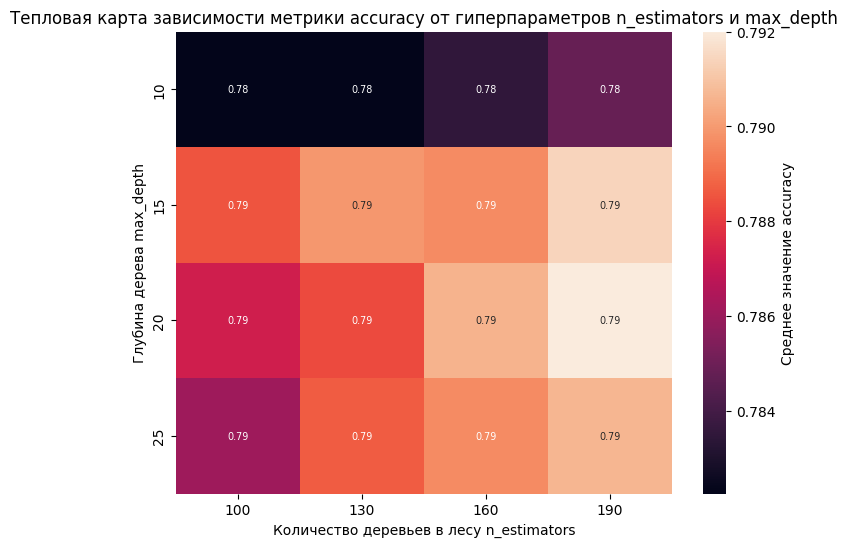

In [ ]:
# Отобразим, как менялась точность при различных гиперпараметрах
visual = pd.pivot_table(pd.DataFrame(grid_search_1.cv_results_),
                        values='mean_test_score',
                        index='param_max_depth',
                        columns='param_n_estimators')

# Построим тепловую карту
fig = plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(
    visual,
    annot=True,
    annot_kws={'fontsize':'x-small'},
    cbar_kws={'label':'Среднее значение accuracy'}
)
heatmap.set_title('Тепловая карта зависимости метрики accuracy от гиперпараметров n_estimators и max_depth', fontsize=12);
heatmap.set_xlabel('Количество деревьев в лесу n_estimators', fontsize=10);
heatmap.set_ylabel('Глубина дерева max_depth', fontsize=10);

> **Вывод по подбору гиперпараметров случайного леса с помощью GridSearchCV**:  
> 1. Значения метрик accuracy по сравнению с базовой оптимизацией ухудшилось на 0.01, что можно игнорировать как погрешность, а $F_1$-score  не изменилось. Так что подбор гиперпараметров методом GridSearch не дал преимущества в данном случае, и стоит попробовать другие методы оптимизации.  
>
> 2. Следует отметить гораздо меньшее затраченное время на подбор гиперпараметров по сравнению с моделью логистической регрессии (в 5 раз!) при одинаковом (или чуть даже превосходящем) значении $F_1$-score.  
>  
> 3. Наилучшими подобранными гиперпараметрами стали: критерий информативности - энтропия Шеннона, максимальная глубина дерева - 20, количество листьев - 5, кол-во деревьев в лесу - 190.  
____

### 3.2. RandomizedSearchCV

#### **3.2.1. Логистическая регрессия**  
При подборе используем ту же сетку гиперпараметров логистической регрессии, что и для метода GridSearchCV.  
При этом зададим количество проверяемых комбинаций гиперпараметров n_iter, равным 10. И сравним затраченное время.

In [ ]:
# Создаем сетку настраиваемых гиперпараметров
param_distributions = [
    {'penalty' : ['l2', None],
     'solver': ['lbfgs', 'sag'],
     'C': [0.01, 0.05, 0.07, 0.5, 1]},
    {'penalty': ['l1', 'l2', None],
     'solver': ['saga'],
     'C': [0.01, 0.05, 0.1, 0.5, 1]}
]

# Создаем объект RandomizedSearchCV с моделью логистической регрессии
random_search = RandomizedSearchCV(
    estimator = linear_model.LogisticRegression(random_state=42, max_iter=300), 
    param_distributions = param_distributions, 
    cv = 5,
    error_score = 'raise',
    n_iter = 10,
    n_jobs = -1
)

# Подбираем параметры, вычисляем и выводим метрики, а также наилучшие гиперпараметры
%time random_search.fit(X_train, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(random_search.score(X_test, y_test)))
y_test_pred = random_search.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search.best_params_))

CPU times: user 15.5 s, sys: 268 ms, total: 15.8 s
Wall time: 7min 42s
accuracy на тестовом наборе: 0.76
f1_score на тестовом наборе: 0.79
Наилучшие значения гиперпараметров: {'solver': 'saga', 'penalty': 'l2', 'C': 0.05}


> **Вывод по подбору гиперпараметров логистической регрессии с помощью RandomizedSearchCV**:  
> 1. Значения метрик accuracy и $F_1$-score получились такими же, как и при методе подбора GridSearch, зато времени на их подбор затрачено 7 минут, то есть в 4 раза меньше!  
>
> 2. Наилучшие гиперпараметры модели при этом подобраны точно такие же.  
____

#### **3.2.2. Случайный лес**  
При подборе используем ту же сетку гиперпараметров случайного леса, что и для метода GridSearchCV.  
При этом зададим количество проверяемых комбинаций гиперпараметров n_iter, равным 10. И сравним затраченное время.

In [ ]:
# Создаем сетку настраиваемых гиперпараметров
param_distributions = {
    'n_estimators' : list(range(100, 200, 30)),
    'criterion' : ['gini', 'entropy'],
    'max_depth': [10, 15, 20, 25],
    'min_samples_leaf' : [5, 7],
}

# Создаем объект RandomizedSearchCV с моделью логистической регрессии
random_search_1 = RandomizedSearchCV(
    estimator = ensemble.RandomForestClassifier(random_state=42), 
    param_distributions = param_distributions, 
    cv = 5,
    error_score = 'raise',
    n_iter = 10,
    n_jobs = -1
)

# Подбираем параметры, вычисляем и выводим метрики, а также наилучшие гиперпараметры
%time random_search_1.fit(X_train, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(random_search_1.score(X_test, y_test)))
y_test_pred = random_search_1.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search_1.best_params_))

CPU times: user 2.93 s, sys: 67 ms, total: 3 s
Wall time: 1min 8s
accuracy на тестовом наборе: 0.77
f1_score на тестовом наборе: 0.80
Наилучшие значения гиперпараметров: {'n_estimators': 190, 'min_samples_leaf': 5, 'max_depth': 20, 'criterion': 'entropy'}


> **Вывод по подбору гиперпараметров случайного леса с помощью RandomizedSearchCV**:  
> 1. Значения метрик accuracy и $F_1$-score получились такими же, как и при методе подбора GridSearch, зато на их подбор затрачена 1 минута, то есть в 6 раз меньше!  
>
> 2. Наилучшие гиперпараметры модели при этом подобраны точно такие же.  
>  
> 3. Стоит отметить, что данные результаты получены с третьей попытки. На первых двух значение $F_1$-score составляло 0.79 (ниже, чем на Baseline), но времени затрачивалось от 53 до 59 секунд. Можно сделать вывод, что это результат случайного выбора гиперапараметров из сетки, который не всегда гарантирует наилучший результат. Однако и он близок к лучшему при существенной экономии времени.
____

 > ### **Промежуточный вывод по базовой оптимизации:**  
 > 
 > Нам удалось несколько улучшить или сохранить на прежнем уровне значение целевой метрики $F_1$-score по сравнению с baseline-решением.   
 >  
 > Мы продемонстрировали более быструю и эффективную работу метода RandomizedSearchCV над GridSearchCV.  
 ---

## 4. Продвинутая оптимизация гиперпараметров моделей

### 4.1. Hyperopt

При необходимости, библиотеку можно установить с помощью команды: `!pip install hyperopt`.  
В нашем случае она установлена и импортирована в первой части ноутбука вместе с функциями, которые нам потребуются. Напомним их:  
* fmin - основная функция, она будет минимизировать наш функционал;  
* tpe - алгоритм оптимизации;  
* hp - включает набор методов для объявления пространства поиска гиперпараметров;  
* trails - используется для логирования результатов.  

In [ ]:
# Выведем версию Hyperopt, чтобы убедиться, что мы можем продолжать работу
print("Версия Hyperopt : {}".format(hyperopt.__version__))

Версия Hyperopt : 0.2.7


#### **4.1.1. Логистическая регрессия**  
При подборе используем ту же сетку гиперпараметров логистической регрессии, что и в предыдущих методах, за исключением метода регуляризации `penalty = 'l1'`, который использует только метод оптимизации функции потерь `solver = 'saga'`. Как мы видели в двух предыдущих случаях, `l1` не оказывался в числе наилучших гиперпараметров, поэтому с целью упрощения кода и экономии ресурсов перестанем к нему обращаться в дальнейшем.   
Для начала зададим количество проверяемых комбинаций гиперпараметров max_eval равным 10 и используем кросс-валидацию.  

In [ ]:
# Зададим пространство поиска гиперпараметров
penalty_list = ['l2', None]
solver_list = ['lbfgs', 'sag', 'saga']

space = {
    'penalty': hp.choice('penalty', penalty_list),
    'solver': hp.choice('solver', solver_list),
    'C' : hp.quniform('C', 0.01, 0.15, 0.02)
}

In [ ]:
# Зафиксируем число для воспроизводимости результата
random_state = 42

# Создадим функцию расчета целевой метрики - понадобится для использования с fmin
def hyperopt_lr(params: dict,
                cv: int = 5,
                X: pd.DataFrame = X_train,
                y: pd.Series = y_train,
                random_state: int = random_state) -> float:
    """Функция получает комбинацию гиперпараметров, а также обучающую выборку
    и вектор ответов и возвращает значение целевой метрики для модели
    логистической регрессии.

    Args:
        params (dict): словарь гиперпараметров.
        cv (int, optional): кол-во фолдов для кросс-валидации; по умолчанию = 5.
        X (pd.DataFrame, optional): обучабщая выборка; по умолчанию = X_train.
        y (pd.Series, optional): вектор ответов; по умолчанию = y_train.
        random_state (int, optional): сид воспроизводимости; по умол. = random_state.

    Returns:
        float: значение целевой метрики
    """

    # Преобразуем комбинацию гиперпараметров в переменную
    params = {
        'penalty': params['penalty'], 
        'solver': params['solver'], 
        'C': float(params['C'])
    }
  
    # Используем эту комбинацию для построения модели
    model = linear_model.LogisticRegression(
        **params,
        random_state=random_state,
        max_iter=500
    )

    # Обучим модель с помошью кросс-валидации
    model.fit(X, y)
    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # Вернем значение метрики со знаком минус с целью ее минимизации
    return -score

In [ ]:
# Начинаем подбор гиперпараметров
%%time

trials = Trials() # Используем для логирования результатов

best = fmin(hyperopt_lr, # написанная нами функция
            space=space, # пространство гиперпараметров
            algo=tpe.suggest, # алгоритм оптимизации (установлен по умолчанию)
            max_evals=10, # максимальное количество итераций
            trials=trials, # логирование результатов
            rstate=np.random.default_rng(random_state)# фиксируем для повторяемости результата
)

print("Наилучшие значения гиперпараметров {}".format(best))

  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



 40%|████      | 4/10 [03:44<05:34, 55.69s/trial, best loss: -0.7939600292497768]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



 50%|█████     | 5/10 [04:16<03:55, 47.19s/trial, best loss: -0.7939600292497768]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 60%|██████    | 6/10 [07:27<06:23, 95.93s/trial, best loss: -0.7939600292497768]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 80%|████████  | 8/10 [12:37<04:09, 124.62s/trial, best loss: -0.7939600292497768]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



100%|██████████| 10/10 [14:57<00:00, 89.80s/trial, best loss: -0.7939600292497768]
Наилучшие значения гиперпараметров {'C': 0.02, 'penalty': 0, 'solver': 0}
CPU times: user 3min 45s, sys: 5.42 s, total: 3min 51s
Wall time: 14min 58s


In [ ]:
# Выведем значения в более понятном виде с использованием созданных ранее списков
print("Наилучшие значения гиперпараметров: penalty = '{0}', solver = '{1}', C = {2}."\
      .format(penalty_list[best['penalty']],
              solver_list[best['solver']],
              best['C']))

Наилучшие значения гиперпараметров: penalty = 'l2', solver = 'lbfgs', C = 0.02.


In [ ]:
# Рассчитаем точность для тестовой выборки
model = linear_model.LogisticRegression(
    penalty = penalty_list[best['penalty']],
    solver = solver_list[best['solver']],
    C = float(best['C']),
    random_state = random_state
)

model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test, y_test)))
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на обучающем наборе: 0.83
accuracy на тестовом наборе: 0.75
f1_score на тестовом наборе: 0.78


> Итак, после 10 итераций мы получили значения метрик, равные baseline-решению, а затратили на это 15 минут!  

Воспользуемся преимуществом метода Hyperopt продолжить оптимизацию с того места, где мы остановились, за счет объекта Trials, который содержит информацию о предыдущиз запусках. Для этого увеличим количество итерацией до 20.  

In [ ]:
# Продолжим подбор гиперпараметров
%%time

best = fmin(hyperopt_lr,
            space=space,
            algo=tpe.suggest,
            max_evals=20, # увеличим максимальное количество итераций с 10 до 20
            trials=trials, # продолжим логирование результатов
            rstate=np.random.default_rng(random_state)
)
print("Наилучшие значения гиперпараметров: penalty = '{0}', solver = '{1}', C = {2}."\
      .format(penalty_list[best['penalty']],
              solver_list[best['solver']],
              best['C']))

 50%|█████     | 10/20 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



 70%|███████   | 14/20 [03:31<05:19, 53.25s/trial, best loss: -0.7939600292497768]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



 75%|███████▌  | 15/20 [04:00<03:42, 44.44s/trial, best loss: -0.7939600292497768]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 80%|████████  | 16/20 [06:58<06:00, 90.09s/trial, best loss: -0.7939600292497768]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 90%|█████████ | 18/20 [11:59<03:58, 119.39s/trial, best loss: -0.7939600292497768]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



100%|██████████| 20/20 [14:12<00:00, 85.23s/trial, best loss: -0.7939600292497768]
Наилучшие значения гиперпараметров: penalty = 'l2', solver = 'lbfgs', C = 0.02.


In [ ]:
# Вновь рассчитаем точность для тестовой выборки
model = linear_model.LogisticRegression(
    penalty = penalty_list[best['penalty']],
    solver = solver_list[best['solver']],
    C = float(best['C']),
    random_state = random_state
)

model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test, y_test)))
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на обучающем наборе: 0.83
accuracy на тестовом наборе: 0.75
f1_score на тестовом наборе: 0.78


> Спустя еще 15 минут и 10 итераций мы получили те же самые результаты. Можно предположить, что дальнейшая оптимизация не принесет существенного успеха.   

Попробуем все же в порядке эксперимента увеличить количество итерацией до максимально разрешенного условиями задачи - 50.  

In [ ]:
# Продолжим подбор гиперпараметров
%%time

best = fmin(hyperopt_lr,
            space=space,
            algo=tpe.suggest,
            max_evals=50, # увеличим максимальное количество итераций до 50
            trials=trials, # продолжим логирование результатов
            rstate=np.random.default_rng(random_state)
)
print("Наилучшие значения гиперпараметров: penalty = '{0}', solver = '{1}', C = {2}."\
      .format(penalty_list[best['penalty']],
              solver_list[best['solver']],
              best['C']))

 78%|███████▊  | 39/50 [05:55<04:16, 23.28s/trial, best loss: -0.7939600292497768]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



 84%|████████▍ | 42/50 [09:53<08:48, 66.02s/trial, best loss: -0.7939600292497768]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



 90%|█████████ | 45/50 [11:53<04:23, 52.65s/trial, best loss: -0.7942009056959869]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 94%|█████████▍| 47/50 [16:36<04:41, 93.74s/trial, best loss: -0.7942009056959869]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



100%|██████████| 50/50 [22:55<00:00, 45.87s/trial, best loss: -0.7942009056959869] 
Наилучшие значения гиперпараметров: penalty = 'l2', solver = 'saga', C = 0.02.
CPU times: user 5min 41s, sys: 11.5 s, total: 5min 53s
Wall time: 22min 56s


In [ ]:
# Вновь рассчитаем точность для тестовой выборки
model = linear_model.LogisticRegression(
    penalty = penalty_list[best['penalty']],
    solver = solver_list[best['solver']],
    C = float(best['C']),
    random_state = random_state
)

model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test, y_test)))
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на обучающем наборе: 0.83
accuracy на тестовом наборе: 0.75
f1_score на тестовом наборе: 0.78


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


> Максимальное количество итераций не дало эффекта: метрики совсем не изменились. При этом было потрачено еще 22 минуты!

Проиллюстрируем изменение точности при различных итерациях.  

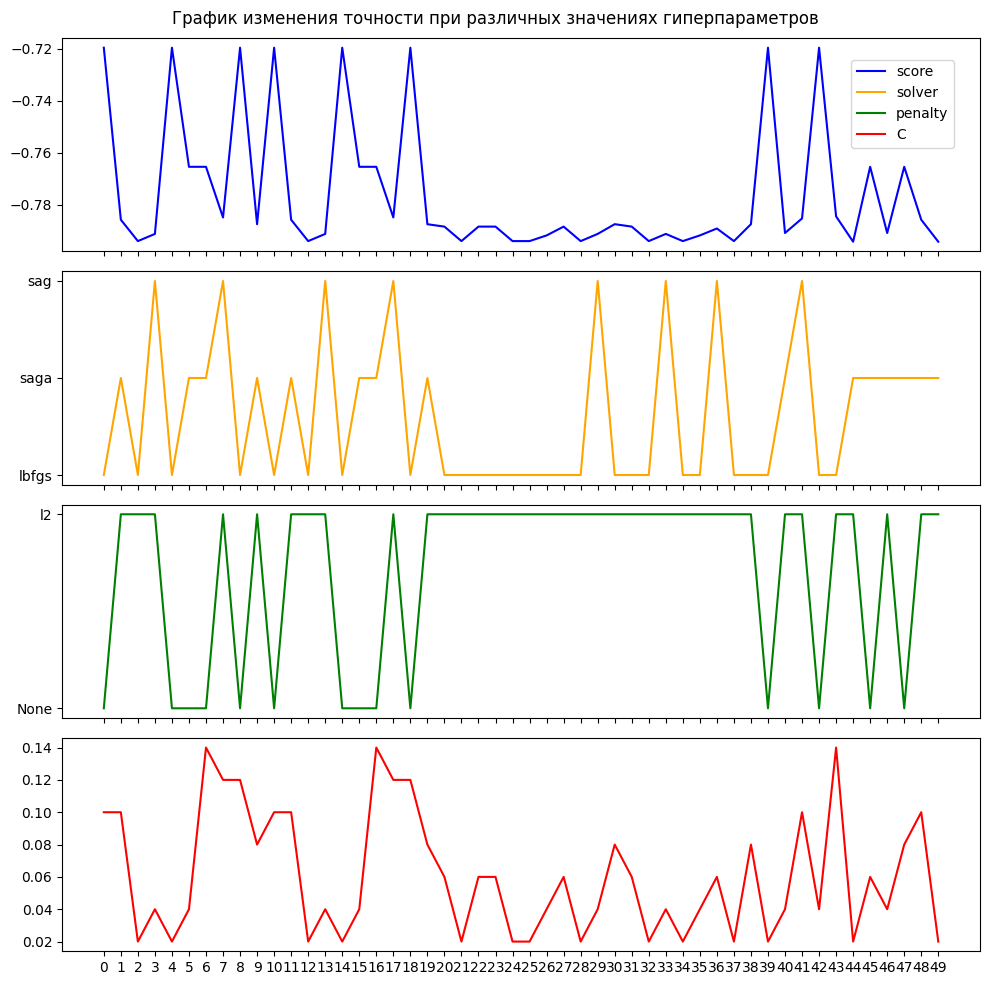

In [ ]:
# Сохраним в массив значения функции потерь и гиперпараметров на всех итерациях
tpe_results = np.array(
    [[x['result']['loss'],
      x['misc']['vals']['solver'][0],
      x['misc']['vals']['penalty'][0],
      x['misc']['vals']['C'][0]]
     for x in trials.trials if x['result']['status'] == 'ok']
)
# Преобразуем массив в датафрейм и подставим значения из наших списков
tpe_results_df = pd.DataFrame(
    tpe_results,
    columns=['score', 'solver', 'penalty', 'C']
)
tpe_results_df['solver'] = tpe_results_df['solver'].apply(lambda x: solver_list[int(x)])
tpe_results_df['penalty'] = tpe_results_df['penalty'].apply(lambda x: penalty_list[int(x)])

# Отрисуем линейные графики, т.к.тепловая карта в данном случае не очень наглядна
fig, ax = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(10,10))
ax[0].plot(tpe_results_df.index, tpe_results_df['score'], label='score', color='blue')
ax[1].plot(tpe_results_df.index, tpe_results_df['solver'], label='solver', color='orange')
ax[2].plot(tpe_results_df.index, tpe_results_df['penalty'].astype('str'), label='penalty', color='green')
ax[3].plot(tpe_results_df.index, tpe_results_df['C'], label='C', color='red')
fig.legend(loc=(0.86, 0.85));
fig.suptitle('График изменения точности при различных значениях гиперпараметров');
plt.setp(ax, xticks=range(50));
fig.tight_layout();
plt.show();

> **Вывод по подбору гиперпараметров логистической регрессии с помощью Hyperopt**:  
> 
> 1. Оптимизация не принесла никакого улучшения метрик по сравнению с baseline-решением. Но при этом было затрачено 52 минуты!  
> 
> 2. Интересно обратить внимание, что на графике метода регуляризации penalty значение `l2`, которое стабильно обеспечивало наилучшие значения точности, вдруг вновь стало меняться, как будто алгоритм перестал учитывать предыдущие успешные результаты. Возможно, это связано с тем, что часто не достигалась сходимость метода оптимизации функции потерь (хотя значение max_iter модели было выставлено с запасом - 500 вместо 300, как на этапе базовой оптимизации).  
>
> 3. Длительная оптимизация (50 итераций) привела к определению наилучших гиперпараметров, практически не отличающихся от полученных в ходе базовой оптимизации: penalty = 'l2', solver = 'saga', C = 0.02. Вот только заняло это у метода Hyperopt 2-6 раз больше времени. Таким образом, метод Hyperopt показал низкую эффективность для данной задачи и/или данной модели.  
---

#### **4.1.2. Случайный лес**  
При подборе используем ту же сетку гиперпараметров случайного леса, что и в предыдущих методах.  
Начнем с задания количества проверяемых комбинаций гиперпараметров max_eval равным 10. При необходимости улучшить результат, продолжим оптимизацию. Также используем кросс-валидацию.  

In [ ]:
# Зададим пространство поиска гиперпараметров
criterion_list = ['gini', 'entropy']

space = {
    'n_estimators': hp.quniform('n_estimators', 100, 200, 30),
    'max_depth' : hp.quniform('max_depth', 10, 25, 5),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 5, 7, 1),
    'criterion' : hp.choice('criterion', criterion_list)
}

In [ ]:
# Зафиксируем число для воспроизводимости результата
random_state = 42

# Создадим функцию расчета целевой метрики - понадобится для использования с fmin
def hyperopt_rf(params: dict,
                cv: int = 5,
                X: pd.DataFrame = X_train,
                y: pd.Series = y_train,
                random_state: int = random_state) -> float:
    """Функция получает комбинацию гиперпараметров, а также обучающую выборку
    и вектор ответов и возвращает значение целевой метрики для модели
    случайного леса.

    Args:
        params (dict): словарь гиперпараметров.
        cv (int, optional): кол-во фолдов для кросс-валидации; по умолчанию = 5.
        X (pd.DataFrame, optional): обучабщая выборка; по умолчанию = X_train.
        y (pd.Series, optional): вектор ответов; по умолчанию = y_train.
        random_state (int, optional): сид воспроизводимости; по умол. = random_state.

    Returns:
        float: значение целевой метрики
    """

    # Преобразуем комбинацию гиперпараметров в переменную
    params = {
        'n_estimators': int(params['n_estimators']), 
        'max_depth': int(params['max_depth']), 
        'min_samples_leaf': int(params['min_samples_leaf']),
        'criterion' : params['criterion']
    }
  
    # Используем эту комбинацию для построения модели
    model = ensemble.RandomForestClassifier(
        **params,
        random_state=random_state
    )

    # Обучим модель с помошью кросс-валидации
    model.fit(X, y)
    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # Вернем значение метрики со знаком минус с целью ее минимизации
    return -score

In [ ]:
# Начинаем подбор гиперпараметров
%%time

trials_2 = Trials() # Используем для логирования результатов

best = fmin(hyperopt_rf, # написанная нами функция
            space=space, # пространство гиперпараметров
            algo=tpe.suggest, # алгоритм оптимизации (установлен по умолчанию)
            max_evals=10, # максимальное количество итераций
            trials=trials_2, # логирование результатов
            rstate=np.random.default_rng(random_state)# фиксируем для повторяемости результата
)

print("Наилучшие значения гиперпараметров {}".format(best))

100%|██████████| 10/10 [03:06<00:00, 18.65s/trial, best loss: -0.8125796238402202]
Наилучшие значения гиперпараметров {'criterion': 0, 'max_depth': 15.0, 'min_samples_leaf': 6.0, 'n_estimators': 120.0}
CPU times: user 35.2 s, sys: 1.04 s, total: 36.3 s
Wall time: 3min 6s


In [ ]:
# Выведем значения в более понятном виде с использованием созданного ранее списка
print(f"Наилучшие значения гиперпараметров: n_estimators = {int(best['n_estimators'])},"\
     ,f"max_depth = {int(best['max_depth'])},"\
     ,f"min_samples_leaf = {int(best['min_samples_leaf'])},"\
     ,f"criterion = '{criterion_list[best['criterion']]}'")

Наилучшие значения гиперпараметров: n_estimators = 120, max_depth = 15, min_samples_leaf = 6, criterion = 'gini'


In [ ]:
# Рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(
    n_estimators = int(best['n_estimators']),
    max_depth = int(best['max_depth']),
    min_samples_leaf = int(best['min_samples_leaf']),
    criterion = criterion_list[best['criterion']],
    random_state = random_state
)

model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test, y_test)))
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на обучающем наборе: 0.92
accuracy на тестовом наборе: 0.77
f1_score на тестовом наборе: 0.79


> Итак, после 10 итераций мы получили значения метрик, даже уступающие baseline-решению. Впрочем, с учетом затраченного времени (3 минуты), это вполне объяснимо.  

Попробуем улучшить результат, проведя дооптимизацию - увеличим количество итераций до 20.  

In [ ]:
# Продолжаем подбор гиперпараметров
%%time

best = fmin(hyperopt_rf,
            space=space,
            algo=tpe.suggest,
            max_evals=20, # максимальное количество итераций увеличиваем до 20
            trials=trials_2, # логирование результатов
            rstate=np.random.default_rng(random_state)
)

# Выведем значения в более понятном виде с использованием созданного ранее списка
print(f"Наилучшие значения гиперпараметров: n_estimators = {int(best['n_estimators'])},"\
     ,f"max_depth = {int(best['max_depth'])},"\
     ,f"min_samples_leaf = {int(best['min_samples_leaf'])},"\
     ,f"criterion = '{criterion_list[best['criterion']]}'")

100%|██████████| 20/20 [02:16<00:00, 13.62s/trial, best loss: -0.8125796238402202]
Наилучшие значения гиперпараметров: n_estimators = 120, max_depth = 15, min_samples_leaf = 6, criterion = 'gini'
CPU times: user 30 s, sys: 658 ms, total: 30.6 s
Wall time: 2min 16s


In [ ]:
# Вновь рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(
    n_estimators = int(best['n_estimators']),
    max_depth = int(best['max_depth']),
    min_samples_leaf = int(best['min_samples_leaf']),
    criterion = criterion_list[best['criterion']],
    random_state = random_state
)

model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test, y_test)))
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на обучающем наборе: 0.92
accuracy на тестовом наборе: 0.77
f1_score на тестовом наборе: 0.79


> После 20 итераций результаты метрик не изменились.  
>
> При этом в обоих случаях лучшим критерием информативности оказывался `gini`, тогда как в предыдущих исследованиях им становился `entropy`, да и остальные параметры леса не приблизились к значениям, которые мы видели на этапах базовой оптимизации. Это может свидетельствовать о том, что мы подобрали не самые лучшие гиперпараметры.  

Проверим, получится ли улучшить результат, проведя дооптимизацию с максимально возможным по условию задачи количеством итераций - 50.  

In [ ]:
# Продолжаем подбор гиперпараметров
%%time

best = fmin(hyperopt_rf,
            space=space,
            algo=tpe.suggest,
            max_evals=50, # максимальное количество итераций увеличиваем до 50
            trials=trials_2, # логирование результатов
            rstate=np.random.default_rng(random_state)
)

# Выведем значения в более понятном виде с использованием созданного ранее списка
print(f"Наилучшие значения гиперпараметров: n_estimators = {int(best['n_estimators'])},"\
     ,f"max_depth = {int(best['max_depth'])},"\
     ,f"min_samples_leaf = {int(best['min_samples_leaf'])},"\
     ,f"criterion = '{criterion_list[best['criterion']]}'")

100%|██████████| 50/50 [06:07<00:00, 12.25s/trial, best loss: -0.8164538403645167]
Наилучшие значения гиперпараметров: n_estimators = 210, max_depth = 25, min_samples_leaf = 5, criterion = 'entropy'
CPU times: user 1min 22s, sys: 1.69 s, total: 1min 24s
Wall time: 6min 7s


In [ ]:
# Вновь рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(
    n_estimators = int(best['n_estimators']),
    max_depth = int(best['max_depth']),
    min_samples_leaf = int(best['min_samples_leaf']),
    criterion = criterion_list[best['criterion']],
    random_state = random_state
)

model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test, y_test)))
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на обучающем наборе: 0.95
accuracy на тестовом наборе: 0.78
f1_score на тестовом наборе: 0.80


> Наконец нам удалось достичь такого же значения метрики $F_1$-score, как и во время базовой оптимизации - 0.80, а вот значение accuracy даже увеличилось на 0.01. Однако результаты все равно не превосходят baseline-решение.  
> 
> Суммарное затраченное время на все 50 итераций составило 9 минут, что не так уж и много. Но неспособность метода превзойти базовое решение с параметрами по умолчанию, ставит под сомнение его использование. Впрочем, результаты могут объясняться тем, что модель случайного леса прекрасно справляется с данной задачей вне зависимости от набора гиперпараметров.  
  
Проиллюстритуем изменение точности при различных гиперпараметрах.  

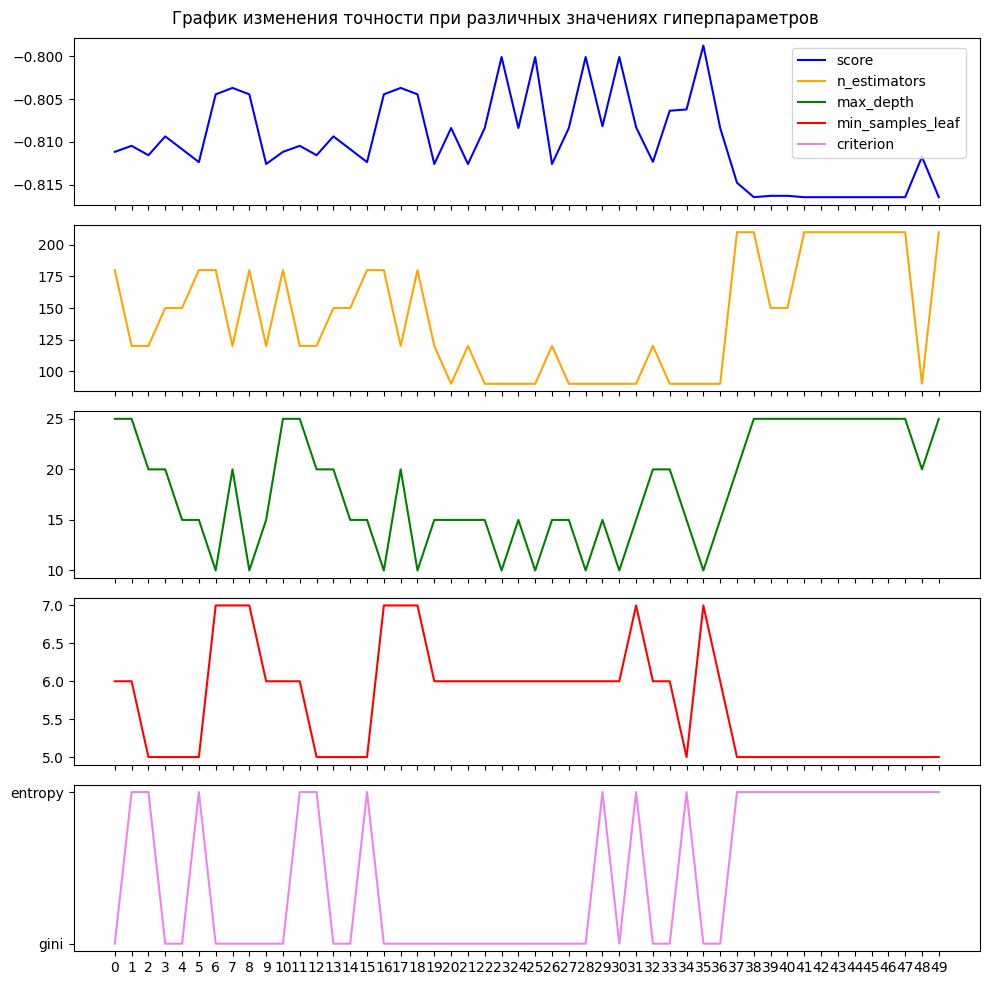

In [ ]:
# Сохраним в массив значения функции потерь и гиперпараметров на всех итерациях
tpe_results = np.array(
    [[x['result']['loss'],
      x['misc']['vals']['n_estimators'][0],
      x['misc']['vals']['max_depth'][0],
      x['misc']['vals']['min_samples_leaf'][0],
      x['misc']['vals']['criterion'][0]]
     for x in trials_2.trials if x['result']['status'] == 'ok']
)
# Преобразуем массив в датафрейм и подставим значения из наших списков
tpe_results_df = pd.DataFrame(
    tpe_results,
    columns=['score', 'n_estimators', 'max_depth', 'min_samples_leaf', 'criterion']
)
tpe_results_df['criterion'] = tpe_results_df['criterion'].apply(lambda x: criterion_list[int(x)])

# Отрисуем линейные графики, т.к.тепловая карта в данном случае не очень наглядна
fig, ax = plt.subplots(nrows=5, ncols=1, sharex=True, figsize=(10,10))
ax[0].plot(tpe_results_df.index, tpe_results_df['score'], label='score', color='blue')
ax[1].plot(tpe_results_df.index, tpe_results_df['n_estimators'], label='n_estimators', color='orange')
ax[2].plot(tpe_results_df.index, tpe_results_df['max_depth'], label='max_depth', color='green')
ax[3].plot(tpe_results_df.index, tpe_results_df['min_samples_leaf'], label='min_samples_leaf', color='red')
ax[4].plot(tpe_results_df.index, tpe_results_df['criterion'], label='criterion', color='violet')
fig.legend(loc=(0.8, 0.84));
fig.suptitle('График изменения точности при различных значениях гиперпараметров');
plt.setp(ax, xticks=range(50));
fig.tight_layout();
plt.show();

> **Вывод по подбору гиперпараметров случайного леса с помощью Hyperopt**:  
> 1. Значения метрики $F_1$-score получилось таким же, как и при методах базовой оптимизации. А вот accuracy улучшилась на 0.01. Но при этом результаты не превосходят baseline-решение.  
> 
> 2. После 50 итераций наилучшие гиперпараметры модели оказались очень похожими на те, что были подобраны на этапе базовой оптимизации. В частости, наилучшим критерием информативности в итоге был признан `entropy`.  
>  
> 3. На графиках отчетливо заметна особенность байесовской оптимизации, реализованной в Hyperopt, - учитывать предыдущие результаты: начиная с 37 итерации метод окончательно "определился", что наилучим критерием информативности является `entropy`. Остается неизменным также количество листьев на дереве = 5. Небольшие вариации отмечаются на оставшихся двух параметрах.  
>
> 4. Метод Hyperopt для модели случайного леса затратил наибольшее количество времени из всех предыдущих - 9 минут при максимальном количестве итераций 50, что ставит под сомнение его эффективность для данной задачи и/или данной модели.  
____

### 4.2. Optuna



In [ ]:
# Устанавливаем библиотеку
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 7.7 MB/s eta 0:00:00


In [ ]:
# Импортируем и выведем текущую версию
import optuna

print("Версия Optuna: {}".format(optuna.__version__))

Версия Optuna: 3.1.1


#### **4.2.1. Логистическая регрессия**  
Сохраним подход к формированию сетки гиперпараметров, как для Hyperopt.   
Для начала зададим количество проверяемых комбинаций гиперпараметров n_trials равным 20 и используем кросс-валидацию.  

In [ ]:
# Зафиксируем число для воспроизводимости результата
random_state = 42

# Создадим функцию расчета целевой метрики
def optuna_lr(trial,
              cv: int = 5,
              X: pd.DataFrame = X_train,
              y: pd.Series = y_train,
              random_state: int = random_state) -> float:
  """Функция получает объект trial, выборки и другие параметры и возвращает
  значение целевой метрики для модели логистической регрессии.

  Args:
      trial : объект Optuna.trial для сохранения результатов оптимизации.
      cv (int, optional): кол-во фолдов для кросс-валидации; по умолчанию = 5.
      X (pd.DataFrame, optional): обучабщая выборка; по умолчанию = X_train.
      y (pd.Series, optional): вектор ответов; по умолчанию = y_train.
      random_state (int, optional): сид воспроизводимости; по умол. = random_state.

  Returns:
      float: значение целевой метрики
  """

  # Задаем пространства поиска гиперпараметров
  penalty_list = ['l2', None]
  solver_list = ['lbfgs', 'sag', 'saga']
  penalty = trial.suggest_categorical('penalty', penalty_list)
  solver = trial.suggest_categorical('solver', solver_list)
  C = trial.suggest_float('C', 0.01, 0.15, step=0.02)

  # Cоздаем модель
  model = linear_model.LogisticRegression(
      penalty = penalty,
      solver = solver,
      C = C,
      max_iter = 500,
      random_state = random_state
  )
  
  # Обучаем модель с помощью кросс-валидации
  model.fit(X, y)
  score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

  # Возвращаем значение метрики
  return score

In [ ]:
# Начинаем подбор гиперпараметров
%%time

# Создаем объект исследования, будем максимизировать значение метрики
study = optuna.create_study(study_name="LogisticRegression", direction="maximize")

# Выполняем оптимизацию гиперпараметров 20 раз
study.optimize(optuna_lr, n_trials=20)

[I 2023-05-18 16:25:27,825] A new study created in memory with name: LogisticRegression
[I 2023-05-18 16:25:36,262] Trial 0 finished with value: 0.7879017552772007 and parameters: {'penalty': 'l2', 'solver': 'lbfgs', 'C': 0.06999999999999999}. Best is trial 0 with value: 0.7879017552772007.
[I 2023-05-18 16:26:54,816] Trial 1 finished with value: 0.7903599972929735 and parameters: {'penalty': 'l2', 'solver': 'sag', 'C': 0.05}. Best is trial 1 with value: 0.7903599972929735.
[I 2023-05-18 16:26:59,450] Trial 2 finished with value: 0.7926327960126269 and parameters: {'penalty': 'l2', 'solver': 'lbfgs', 'C': 0.03}. Best is trial 2 with value: 0.7926327960126269.
[I 2023-05-18 16:27:05,066] Trial 3 finished with value: 0.7902171664645037 and parameters: {'penalty': 'l2', 'solver': 'lbfgs', 'C': 0.05}. Best is trial 2 with value: 0.7926327960126269.
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_rati

CPU times: user 5min, sys: 4.67 s, total: 5min 5s
Wall time: 20min 48s


In [ ]:
# Выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'penalty': 'l2', 'solver': 'saga', 'C': 0.03}
f1_score на обучающем наборе: 0.79


In [ ]:
# Выводим результаты на тестовой выборке
model = linear_model.LogisticRegression(**study.best_params,random_state=random_state)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test, y_test)))
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.76
f1_score на тестовом наборе: 0.78


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


> Итак, после 20 итераций, занявших почти 21 минуту, мы получили значение $F_1$-score равное baseline-решению и Hyperopt, но меньше на 0.01, чем при базовой оптимизации.
> 
> Выигрыш по времени по сравнению с Hyperopt составил около 9 минут (сравниваем с результатами первых 10 итераций Hyperopt). И при этом сразу был найден наилучший метод оптимизации функции потерь solver = 'saga' (у Hyperopt спустя первые 20 итераций он не был найден). 

Поскольку подобранные гиперпараметры по итогам 20 итераций очень близки к наилучшим, найденным во всех предыдущих методах оптимизации, дальнейшие поиски вряд ли принесут ощутимое улучшение метрик и изменение параметров. Но в целях эксперимента проведем дополнительные 30 итераций и проверим эффективность библиотеки Optuna.


In [ ]:
# Продолжим подбор гиперпараметров
%%time

# Добавим до 50 еще 30 итераций n_trials
study.optimize(optuna_lr, n_trials=30)

[I 2023-05-18 16:50:58,287] Trial 20 finished with value: 0.7867462132357887 and parameters: {'penalty': 'l2', 'solver': 'saga', 'C': 0.09}. Best is trial 17 with value: 0.7931527786353183.
[I 2023-05-18 16:52:35,549] Trial 21 finished with value: 0.7931527786353183 and parameters: {'penalty': 'l2', 'solver': 'saga', 'C': 0.03}. Best is trial 17 with value: 0.7931527786353183.
[I 2023-05-18 16:54:40,897] Trial 22 finished with value: 0.7907284724091234 and parameters: {'penalty': 'l2', 'solver': 'saga', 'C': 0.05}. Best is trial 17 with value: 0.7931527786353183.
[I 2023-05-18 16:55:55,016] Trial 23 finished with value: 0.7878551093895769 and parameters: {'penalty': 'l2', 'solver': 'saga', 'C': 0.01}. Best is trial 17 with value: 0.7931527786353183.
[I 2023-05-18 16:57:19,620] Trial 24 finished with value: 0.7931527786353183 and parameters: {'penalty': 'l2', 'solver': 'saga', 'C': 0.03}. Best is trial 17 with value: 0.7931527786353183.
[I 2023-05-18 16:59:28,307] Trial 25 finished with

CPU times: user 11min 48s, sys: 2.89 s, total: 11min 51s
Wall time: 50min 44s


In [ ]:
# Выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'penalty': 'l2', 'solver': 'saga', 'C': 0.03}
f1_score на обучающем наборе: 0.79


In [ ]:
# Выводим результаты на тестовой выборке
model = linear_model.LogisticRegression(**study.best_params,random_state=random_state)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test, y_test)))
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.76
f1_score на тестовом наборе: 0.78


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


> Как мы и ожидали, дальнейшего улучшения после 50 итераций не произошло (а времени потребовалось еще 50 минут!).  

Воспользуемся встроенным в библиотеку функционалом графического отображения процесса и результатов оптимизации, который помогает принимать лучшие решения, видеть влияние различных гиперпараметров на производительность модели.  

In [ ]:
# Проверим доступность встроенной визуализации
optuna.visualization.is_available()

True

Построим график истории оптимизации. Он отображает количество испытаний на оси Х и метрику на оси Y.  
Следует использовать эту диаграмму, чтобы проверить, идет ли оптимизация гиперпараметров в правильном направлении или нет.

In [ ]:
optuna.visualization.plot_optimization_history(study, target_name="f1_score")

![LogisticRegression_Optimisation_History_plot](img/Optuna_421_LR_1_History_plot.png)

> Как можно видеть, на протяжении всех 50 итераций метрика $F_1$-score постоянно максимизируется.  

Теперь построим диаграмму важности гиперпараметров. Она помогает понять, какие гиперпараметры вносят больший вклад в максимизацию метрики.  

In [ ]:
optuna.visualization.plot_param_importances(study, target_name="f1_score")

![LogisticRegression_Hyperparameter_Importances](img/Optuna_421_LR_2_Hyperparameters_plot.png)

> Из диаграммы можно сделать вывод, что стоит обратить большее внимание на настройку метода регуляризации `penalty`. А вот коэффициент `C` имеет самое низкое значение.  

Наконец, построим графики контуров отношений гиперпараметров. Они позволят увидеть связь между различными комбинациями гиперпараметров и значением метрики для этих комбинаций.  

In [ ]:
optuna.visualization.plot_contour(study, params=["penalty", 'solver', "C"],
                                  target_name="f1_score")

![LogisticRegression_Contour_Plot](img/Optuna_421_LR_3_Contour_plot.png)

> Наиболее темные области, как следует из легенды, соответствуют высокому значению метрики $F_1$-score.  
> Наилучшими выглядят значениями гиперпараметров `penalty = 'l2', solver = 'saga', C < 0.05`. 















> **Вывод по подбору гиперпараметров логистической регрессии с помощью Optuna**:  
> 1. После 20 итераций и 21 минуты алгоритм подобрал гиперпараметры, которые по метрике accuracy превзошли baseline-решение, а также Hyperopt на 0.01, а по целевой метрике $F_1$-score остались на таком же уровне - 0.78.  
>
> 2. Однако целевая метрика в данном случае оказалась на 0.01 хуже, чем при использовании базовых алгоритмов оптимизации.  
> 
> 3. По времени работы, библиотека Optuna выглядит более предпочтительной нежели Hyperopt для данной задачи и данной модели (21 минута против 52 минут), но значительно проигрывает методу RandomizedSearchCV, которому потребовалось около 8 минут, чтобы подобрать наилучшие гиперпараметры, достигнув при этом более выского значения $F_1$-score.
---



#### **4.2.2. Случайный лес**  
Сохраним подход к формированию сетки гиперпараметров, как для Hyperopt.   
Для начала зададим количество проверяемых комбинаций гиперпараметров n_trials равным 20 и используем кросс-валидацию.  

In [ ]:
# Зафиксируем число для воспроизводимости результата
random_state = 42

# Создадим функцию расчета целевой метрики
def optuna_rf(trial,
              cv: int = 5,
              X: pd.DataFrame = X_train,
              y: pd.Series = y_train,
              random_state: int = random_state) -> float:
  """Функция получает объект trial, выборки и другие параметры и возвращает
  значение целевой метрики для модели случайного леса.

  Args:
      trial : объект Optuna.trial для сохранения результатов оптимизации.
      cv (int, optional): кол-во фолдов для кросс-валидации; по умолчанию = 5.
      X (pd.DataFrame, optional): обучабщая выборка; по умолчанию = X_train.
      y (pd.Series, optional): вектор ответов; по умолчанию = y_train.
      random_state (int, optional): сид воспроизводимости; по умол. = random_state.

  Returns:
      float: значение целевой метрики
  """

  # Задаем пространства поиска гиперпараметров
  criterion_list = ['gini', 'entropy']
  n_estimators = trial.suggest_int('n_estimators', 100, 190, step=30)
  max_depth = trial.suggest_int('max_depth', 10, 25, step=5)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 5, 7, step=1)
  criterion = trial.suggest_categorical('criterion', criterion_list)

  # Cоздаем модель
  model = ensemble.RandomForestClassifier(
      n_estimators = n_estimators,
      max_depth = max_depth,
      min_samples_leaf = min_samples_leaf,
      criterion = criterion,
      random_state = random_state
  )
  
  # Обучаем модель с помощью кросс-валидации
  model.fit(X, y)
  score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

  # Возвращаем значение метрики
  return score

In [ ]:
# Начинаем подбор гиперпараметров
%%time

# Создаем объект исследования, будем максимизировать значение метрики
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")

# Выполняем оптимизацию гиперпараметров 20 раз
study.optimize(optuna_rf, n_trials=20)

[I 2023-05-18 19:09:53,342] A new study created in memory with name: RandomForestClassifier
[I 2023-05-18 19:10:07,678] Trial 0 finished with value: 0.8125420070751825 and parameters: {'n_estimators': 130, 'max_depth': 15, 'min_samples_leaf': 5, 'criterion': 'entropy'}. Best is trial 0 with value: 0.8125420070751825.
[I 2023-05-18 19:10:18,121] Trial 1 finished with value: 0.8060429894497148 and parameters: {'n_estimators': 130, 'max_depth': 25, 'min_samples_leaf': 7, 'criterion': 'entropy'}. Best is trial 0 with value: 0.8125420070751825.
[I 2023-05-18 19:10:28,058] Trial 2 finished with value: 0.8157343853767269 and parameters: {'n_estimators': 130, 'max_depth': 25, 'min_samples_leaf': 5, 'criterion': 'entropy'}. Best is trial 2 with value: 0.8157343853767269.
[I 2023-05-18 19:10:40,154] Trial 3 finished with value: 0.8088600057473192 and parameters: {'n_estimators': 160, 'max_depth': 20, 'min_samples_leaf': 7, 'criterion': 'entropy'}. Best is trial 2 with value: 0.8157343853767269.


CPU times: user 1min 1s, sys: 1 s, total: 1min 2s
Wall time: 4min 54s


In [ ]:
# Выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 160, 'max_depth': 25, 'min_samples_leaf': 5, 'criterion': 'entropy'}
f1_score на обучающем наборе: 0.82


In [ ]:
# Выводим результаты на тестовой выборке
model = ensemble.RandomForestClassifier(**study.best_params,random_state=random_state)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test, y_test)))
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.77
f1_score на тестовом наборе: 0.79


> Итак, после 20 итераций, занявших чуть меньше 5 минут, мы получили близкие к наилучшим, но недостаточно высокие значения метрик на тестовой выборке. При этом были подобраны близкие к наилучшим значения гиперпараметров, в частости `criterion = 'entropy'`.  
> 
> Hyperopt за те же 20 итераций и примерно такое же время продемонстрировал такие же значения метрик, но вот значение `criterion` все еще равнялось 'gini'. Так что на данном этапе можно считать алгоритм Optuna предпочтительным.

Поскольку базовые методы оптимизации позволяли достигать $F_1$-score = 0.8, а время, затрачиваемое Optuna невелико, попробуем увеличить число итераций до 50 и посмотреть, к чему это приведет.

In [ ]:
# Продолжим подбор гиперпараметров
%%time

# Добавим до 50 еще 30 итераций n_trials
study.optimize(optuna_rf, n_trials=30)

[I 2023-05-18 19:22:39,093] Trial 20 finished with value: 0.8180228086989535 and parameters: {'n_estimators': 160, 'max_depth': 25, 'min_samples_leaf': 5, 'criterion': 'entropy'}. Best is trial 5 with value: 0.8180228086989535.
[I 2023-05-18 19:22:54,279] Trial 21 finished with value: 0.8180228086989535 and parameters: {'n_estimators': 160, 'max_depth': 25, 'min_samples_leaf': 5, 'criterion': 'entropy'}. Best is trial 5 with value: 0.8180228086989535.
[I 2023-05-18 19:23:07,119] Trial 22 finished with value: 0.8180228086989535 and parameters: {'n_estimators': 160, 'max_depth': 25, 'min_samples_leaf': 5, 'criterion': 'entropy'}. Best is trial 5 with value: 0.8180228086989535.
[I 2023-05-18 19:23:19,859] Trial 23 finished with value: 0.8180228086989535 and parameters: {'n_estimators': 160, 'max_depth': 25, 'min_samples_leaf': 5, 'criterion': 'entropy'}. Best is trial 5 with value: 0.8180228086989535.
[I 2023-05-18 19:23:34,035] Trial 24 finished with value: 0.8116646875929089 and paramet

CPU times: user 1min 31s, sys: 1.42 s, total: 1min 33s
Wall time: 6min 30s


In [ ]:
# Выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 160, 'max_depth': 25, 'min_samples_leaf': 5, 'criterion': 'entropy'}
f1_score на обучающем наборе: 0.82


In [ ]:
# Выводим результаты на тестовой выборке
model = ensemble.RandomForestClassifier(**study.best_params,random_state=random_state)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test, y_test)))
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.77
f1_score на тестовом наборе: 0.79


> Как и в случае со линейной регрессией, дополнительные 30 итераций не принесли никакого эффекта - метрики остались на том же уровне, а в логах можно видеть, что наилучшие значения гиперпараметров были подобраны еще на 5-й итерации.  
>
> Хорошо, что дополнительные итерации потребовали лишь 6,5 минут времени, однако мы не будем их учитывать в дальнейшем сравнении, т.к. результаты были получены после 20 итераций и 5 минут.

Построим график истории оптимизации. Он отображает количество испытаний на оси Х и метрику на оси Y.  
Следует использовать эту диаграмму, чтобы проверить, идет ли оптимизация гиперпараметров в правильном направлении или нет.

In [ ]:
optuna.visualization.plot_optimization_history(study, target_name="f1_score")

![RandomForest_Classifier_Optimisation_History_plot](img/Optuna_422_RF_1_History_plot.png)

> Как можно видеть, на протяжении всех 50 итераций метрика $F_1$-score постоянно максимизируется.  

Теперь построим диаграмму важности гиперпараметров. Она помогает понять, какие гиперпараметры вносят больший вклад в максимизацию метрики.  

In [ ]:
optuna.visualization.plot_param_importances(study, target_name="f1_score")

![RandomForestClassifier_Hyperparameter_Importances](img/Optuna_422_RF_2_Hyperparameters_plot.png)

> Наибольший вклад вносит минимальное количество листьев на ветви `min_samples_leaf`, затем `criterion` и так далее. А вот количество деревьев `n_estimators` играет наименьшую роль - все потому, что в случайном лесу используются глубокие деревья, способные сформировать полноценный прогноз.  

Наконец, построим графики контуров отношений гиперпараметров. Они позволят увидеть связь между различными комбинациями гиперпараметров и значением метрики для этих комбинаций.  

In [ ]:
optuna.visualization.plot_contour(study, params=['min_samples_leaf', 'criterion', 'max_depth', 'n_estimators'],
                                  target_name="f1_score")

![RandomForestClassifier_Contour_Plot](img/Optuna_422_RF_3_Contour_plot.png)

> Наиболее темные области, как следует из легенды, соответствуют высокому значению метрики $F_1$-score.  
> Наилучшими выглядят значениями гиперпараметров `criterion = 'entropy', max_depth  >= 20, min_samples_leaf = 5, n_estimators >= 160`. 















> **Вывод по подбору гиперпараметров случайного леса с помощью Optuna**:  
> 1. Наилучший набор гиперпараметров был подобран в течение первых 20 итераций (точнее на 5-й итерации) в течение 5 минут, что почти вдвое быстрее, чем с помощью библиотеки Hyperopt.  
>
> 2. Однако целевая метрика $F_1$-score даже после 50 итераций так и осталась на уровне 0.79 и не дотянула до baseline-решения = 0.80, что говорит не в пользу Optuna.
> 
> 3. Учитывая приведенные факты, эффективность библиотеки можно рассматривать с точки зрения ее возможностей визуализации, которые помогают лучше понять взаимосвязи гиперпараметров и сосредоточиться затем на работе с наиболее важными из них.
---



 > ### **Промежуточный вывод по продвинутой оптимизации:**  
 > 
 > В целом, продвинутые методы в данной задаче предсказания биологического ответа с данными моделями линейной регресии и случайного леса не полностью оправдали заложенный в них потенциал: подбор гиперпараметров происходил дольше, чем в базовых методах, а результаты едва превосходили базовые. В случае с моделью логистической регрессии значение метрики оказалось даже хуже, чем при использовании базовых методов оптимизации.  
 >  
 > Из двух рассмотренных библиотек наиболее простой в использовании представляется Optuna, предлагая к тому же полезный графический функционал. Она также намного быстрее Hyperopt, хотя не всегда показывает лучшие результаты метрик.  
 > 
 > Примечание: при выгрузке ноутбука из Google Colab графики Optuna не созранились - пришлось сохранить их отдельно и вставить в ноутбук в виде изображений.
 ---

## 5. Общий вывод по задаче  

> 1. Мы рассмотрели в сравнении 4 метода оптимизации гиперпараметров для двух моделей машинного обучения, научились использовать их функционал, увидели на практике эффективность каждого из методов.  
> 
> 2. Для сравнения рассмотренных методов сведем в одну таблицу итоговые данные по целевой метрике $F_1$-score и времени подбора наилучших гиперпараметров: 

|  | Logistic | Regression | \| | RandomForestClassifier | ForestClassifier |
|---|---:|---:|---|---:|---:|
|  | $F_1$-score | Time | \| | $F_1$-score | Time |
| Baseline | 0.78 | 0 min | \| | 0.80 | 0 min |
| GridSearchCV | 0.79 | 31 min | \| | 0.80 | 6 min |
| RandomizedSearchCV | 0.79 | 8 min | \| | 0.80 | 1 min |
| Hyperopt | 0.78 | 52 min | \| | 0.80 | 9 min |
| Optuna | 0.78 | 21 min | \| | 0.79 | 5 min |

> 3. Как следует из таблицы, все методы оптимизации показали примерно одинаковый результат целевой метрики (в пределах погрешности). Однако продвинутые методы требовали больше времени на нахождение наилучшего набора гиперпараметров. На втором месте по длительности работы следует расположить алгоритм GridSearchCV в виду его прямолинейной работы.
>
> 4. Отметим, что наиболее времязатратной оказалась модель логистической регрессии (22 минуты в среднем на каждый из алгоритмов), в том время как модели случайного леса требовалось в среднем чуть больше 4 минут на подбор. При этом модель случайного леса стабильно показывала более высокий результат целевой метрики, который так и не был достигнут при использовании логистической регрессии.  
>
> 5. Стоит обратить внимание на более сложный синтаксис продвинутых методов, необходимость создания специальной функции для оптимизации метрики, а также явное использование кросс-валидации. Всех этих недостатков лишены рассмотренные базовые методы, входящие в библиотеку sklearn. С учетом полученных результатов, использование продвинутых методов не представляется целесообразным для данной задачи и данных моделей, что, впрочем, не свидетельствует об их возможной неэффективности в других случаях применения.
>
> 6. Приобретенные навыки и полученный арсенал средств позволят в последующей работе с большей эффективностью достигать поставленных целей.  
---